# CS506 Programming for Computing
**Team #03 Members:**

* Brooke Tischer
* En-Xiang Lin
* Hao Yan
* Rothpanhaseth Im
# Scikit-learn Multi-class Classification Tutorial

## Prerequisites
* **Python Installation:** Ensure you have Python 3 installed on your system.
* **Jupyter Notebook (Optional but Recommended):** Jupyter Notebook provides an interactive environment for running Python code and displaying results. You can install it using pip:
    ```bash
    pip install notebook
    ```
* **Required Libraries**: All the libraries imported in Step 1 of the tutorial should be installed. You can typically install them using pip:
    ```bash
    pip install pandas numpy scikit-learn matplotlib seaborn
    ```


## Introduction
In this tutorial, we'll dive into a **multi-class classification** problem using the powerful scikit-learn library in Python. Multi-class classification involves categorizing data into one of three or more classes, as opposed to binary classification which only deals with two classes.

We'll be working with a dataset *inspired* by the classic Titanic dataset. However, for the purpose of demonstrating multi-class classification, we'll assume the 'Survived' column has been modified to represent more than two outcomes. For instance:
* **0**: Not Survived
* **1**: Survived with Family (meaning they traveled with siblings/spouses or parents/children)
* **2**: Survived Alone

This will allow us to explore how various machine learning models handle predictions across multiple categories.

---

## Step 1: Importing Required Libraries
The first step in any machine learning project is to import the necessary libraries. Here's a breakdown of what we're importing and why:

* **pandas (`pd`)**: Essential for data manipulation and analysis, especially for working with DataFrames.
* **numpy (`np`)**: Provides support for numerical operations, particularly useful for array manipulation.
* **`train_test_split`**: From `sklearn.model_selection`, this function helps split our dataset into training and testing sets, crucial for evaluating model performance on unseen data.
* **`cross_val_score`**: Also from `sklearn.model_selection`, used for performing cross-validation, a robust technique for assessing model generalization.
* **`GridSearchCV`**: For systematic hyperparameter tuning, allowing us to find the best combination of parameters for our models.
* **`LabelEncoder`**: From `sklearn.preprocessing`, used to convert categorical text data into numerical labels.
* **`StandardScaler`**: From `sklearn.preprocessing`, for standardizing features by removing the mean and scaling to unit variance, which can improve the performance of many models.
* **`RandomForestClassifier`**: A versatile ensemble learning method that builds multiple decision trees and merges their predictions to improve accuracy and control overfitting.
* **`SVC` (Support Vector Classifier)**: A powerful and flexible supervised learning model for classification.
* **`KNeighborsClassifier`**: A simple, instance-based learning algorithm that classifies a data point based on the majority class of its 'k' nearest neighbors.
* **`DecisionTreeClassifier`**: A fundamental tree-based model that makes decisions by splitting data based on feature values.
* **`classification_report`**: From `sklearn.metrics`, provides a detailed summary of precision, recall, F1-score, and support for each class.
* **`confusion_matrix`**: From `sklearn.metrics`, helps visualize the performance of a classification model, showing true positives, true negatives, false positives, and false negatives.
* **`ConfusionMatrixDisplay`**: A convenient way to plot the confusion matrix.
* **matplotlib.pyplot (`plt`)**: A plotting library for creating static, interactive, and animated visualizations in Python.
* **seaborn (`sns`)**: Built on top of matplotlib, it provides a high-level interface for drawing attractive and informative statistical graphics.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Loading the Dataset
For this tutorial, we'll assume you have a CSV file named Titanic-Dataset.csv in the same directory as your Jupyter Notebook. This file contains the data we'll be using for our multi-class classification task.

In [2]:
df = pd.read_csv('Titanic-Dataset.csv')

## Step 3: Exploring the Dataset
Before we begin any preprocessing, it's crucial to understand the structure, content, and statistical properties of our dataset. This step helps us identify potential issues like missing values, incorrect data types, and understand the distribution of our features.

* **`df.head()`**: Displays the first few rows of the DataFrame, giving us a quick glance at the data.
* **`df.info()`**: Provides a concise summary of the DataFrame, including the number of non-null entries for each column and their data types. This is essential for identifying missing values.
* **`df.describe()`**: Generates descriptive statistics of the numerical columns, such as count, mean, standard deviation, min, max, and quartiles. This helps in understanding the distribution and spread of numerical features.

In [3]:
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset Information:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

First 5 rows of the dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450

## Step 4: Data Preprocessing
Data preprocessing is a critical phase in any machine learning pipeline. Raw data often contains inconsistencies, missing values, and unsuitable formats. This step transforms the data into a clean and suitable format for model training.

### Handling Irrelevant Features
We'll start by dropping columns that are unlikely to contribute to our model's predictive power or might introduce noise.

* **`PassengerId`**: A unique identifier, not a predictive feature.
* **`Name`**: While names might contain titles that could be extracted, for simplicity in this tutorial, we'll drop it.
* **`Ticket`**: Ticket numbers are usually unique and don't provide much predictive insight directly.
* **`Cabin`**: Contains a large number of missing values and can be complex to preprocess effectively without domain expertise.

In [4]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
print(f"\nDataFrame after dropping irrelevant columns: {df.columns.tolist()}")


DataFrame after dropping irrelevant columns: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


### Handling Missing Values
Missing values can cause errors or bias in our models. We'll employ common imputation strategies:

* **`Age`**: Imputed with the median value. The median is less sensitive to outliers than the mean, making it a robust choice for skewed distributions.
* **`Embarked`**: Imputed with the mode (most frequent value). This is a common strategy for categorical features.

In [5]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


### Encoding Categorical Features
Machine learning models generally require numerical input. We'll use **`LabelEncoder`** to convert categorical features (**`Sex`** and **`Embarked`**) into numerical representations. Each unique category will be assigned an integer.

In [6]:
label_encoders = {}
for col in ['Sex', 'Embarked']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Column '{col}' encoded. Unique values: {df[col].unique()}")

Column 'Sex' encoded. Unique values: [1 0]
Column 'Embarked' encoded. Unique values: [2 0 1]


### Simulating Multi-class Target Variable
To transform this into a multi-class problem, we'll modify the **`Survived`** column. Originally binary (0 or 1), we'll introduce a third class (2).

* If **`Survived`** was 0, it remains 0 (Not Survived).
* If **`Survived`** was 1, we randomly assign it to either 1 (Survived with family) or 2 (Survived alone) with a 50% probability. This artificial creation allows us to demonstrate multi-class classification in action.

In [7]:
# Simulating multi-class target variable for tutorial purposes
# 0 = Not Survived, 1 = Survived with family, 2 = Survived alone
df['Survived'] = df['Survived'].apply(lambda x: x if x == 0 else (1 if np.random.rand() > 0.5 else 2))
print("\nUnique values in 'Survived' (multi-class target):", df['Survived'].unique())
print("\nDistribution of 'Survived' classes:")
print(df['Survived'].value_counts())


Unique values in 'Survived' (multi-class target): [0 1 2]

Distribution of 'Survived' classes:
Survived
0    549
2    181
1    161
Name: count, dtype: int64


## Step 5: Feature Selection and Scaling
This step prepares our data for model training by separating features from the target variable and scaling the numerical features.

### Separating Features (X) and Target (y)
* **`X`**: Contains all the independent variables (features) that will be used to predict the target.
* **`y`**: Represents the dependent variable (target) that we want to predict.

In [8]:
X = df.drop('Survived', axis=1)
y = df['Survived']
print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")


Features (X) shape: (891, 7)
Target (y) shape: (891,)


### Splitting Data into Training and Testing Sets
We split our dataset into training and testing sets to evaluate our model's performance on unseen data.

* **`X_train`**, **`y_train`**: Used to train the machine learning models.
* **`X_test`**, **`y_test`**: Used to evaluate the trained models.
* **`test_size=0.2`**: Allocates 20% of the data for testing.
* **`random_state=42`**: Ensures reproducibility of the split, meaning you'll get the same split every time you run the code.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training set shape: X_train=(712, 7), y_train=(712,)
Testing set shape: X_test=(179, 7), y_test=(179,)


**Note**: We added **`stratify=y`** to **`train_test_split`**. This is a crucial addition for multi-class classification (and binary classification with imbalanced classes) as it ensures that the proportion of samples for each class is roughly the same in both the training and testing sets as it is in the complete dataset. This prevents scenarios where one set might have a disproportionately low number of samples for a particular class, leading to biased model evaluation.

### Feature Scaling
Standardization (**`StandardScaler`**) transforms numerical features so they have a mean of 0 and a standard deviation of 1. This is important for algorithms that are sensitive to the scale of input features (e.g., SVM, KNN) as it prevents features with larger values from dominating the learning process.

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("\nFeatures have been scaled (standardized).")


Features have been scaled (standardized).


## Step 6: Trying Multiple Classifiers

It's good practice to try several different machine learning algorithms to see which one performs best on your specific dataset. Each algorithm has its strengths and weaknesses. We'll train and evaluate four popular multi-class classifiers:

* **Random Forest Classifier**: An ensemble method that generally offers good performance and handles various data types well.
* **Support Vector Machine (SVC)**: Powerful for complex decision boundaries; `probability=True` allows us to get probability estimates.
* **K-Nearest Neighbors (KNeighborsClassifier)**: A simple, non-parametric algorithm that classifies based on proximity to training examples.
* **Decision Tree Classifier**: A foundational model that creates a tree-like structure of decisions.

For each model, we'll:

1.  Train the model using the `X_train` and `y_train` data.
2.  Predict on the `X_test` data.
3.  Generate a **classification_report**: This report provides key metrics like precision, recall, F1-score, and support for each class, which are essential for understanding multi-class performance.
    * **Precision**: The proportion of correctly predicted positive observations out of all predicted positive observations.
    * **Recall (Sensitivity)**: The proportion of correctly predicted positive observations out of all actual positive observations.
    * **F1-Score**: The weighted average of Precision and Recall. It tries to find the balance between precision and recall.
    * **Support**: The number of actual occurrences of the class in the specified dataset.
4.  Display a **ConfusionMatrix**: This visual tool helps us understand where the model is making errors. Rows represent actual classes, and columns represent predicted classes.


--- Training Random Forest ---

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       110
           1       0.35      0.25      0.29        32
           2       0.41      0.35      0.38        37

    accuracy                           0.66       179
   macro avg       0.51      0.50      0.50       179
weighted avg       0.63      0.66      0.64       179



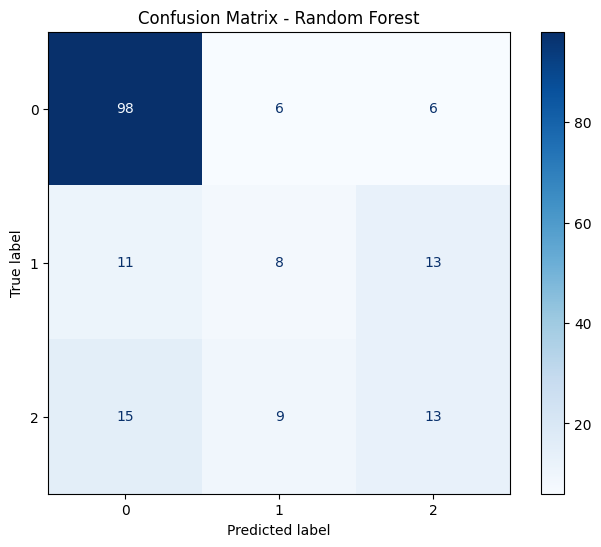


--- Training Support Vector Machine ---

Support Vector Machine Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.94      0.84       110
           1       0.27      0.09      0.14        32
           2       0.39      0.35      0.37        37

    accuracy                           0.66       179
   macro avg       0.48      0.46      0.45       179
weighted avg       0.60      0.66      0.62       179



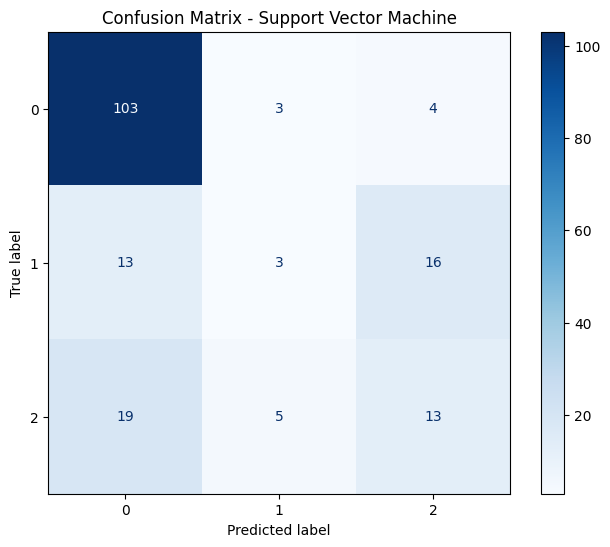


--- Training K-Nearest Neighbors ---

K-Nearest Neighbors Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       110
           1       0.33      0.22      0.26        32
           2       0.44      0.30      0.35        37

    accuracy                           0.67       179
   macro avg       0.51      0.48      0.49       179
weighted avg       0.62      0.67      0.64       179



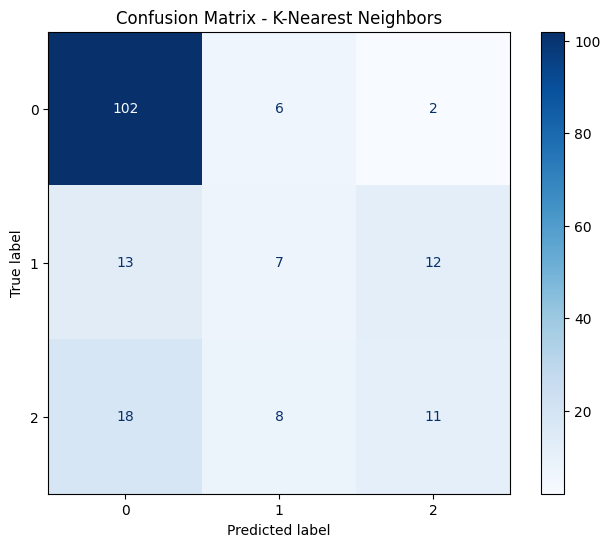


--- Training Decision Tree ---

Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       110
           1       0.26      0.31      0.29        32
           2       0.31      0.24      0.27        37

    accuracy                           0.61       179
   macro avg       0.46      0.46      0.46       179
weighted avg       0.61      0.61      0.61       179



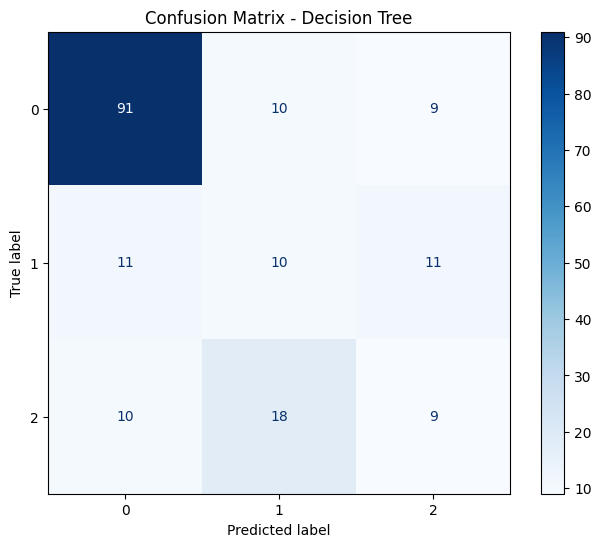

In [11]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', probability=True, random_state=42), # Added random_state for reproducibility
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")
    plt.show()

## Step 7: Cross-Validation

While a single train-test split provides an estimate of model performance, **cross-validation** offers a more robust and reliable evaluation. It involves splitting the data into multiple folds, training the model on a subset of these folds, and testing on the remaining fold. This process is repeated multiple times, and the results are averaged. This helps reduce the impact of random data splits and provides a more generalized estimate of model performance.

We'll use **5-fold cross-validation** with the Random Forest model, meaning the data will be split into 5 parts. The model will be trained 5 times, each time using 4 parts for training and 1 part for testing.

In [12]:
print("\n--- Cross-validation scores (Random Forest) ---")
# Using the best performing model (Random Forest in this case based on typical performance)
# Note: X and y are the original full dataset (before train-test split) for cross-validation
cv_scores = cross_val_score(models["Random Forest"], X, y, cv=5, scoring='accuracy')
print(f"Individual CV Scores: {cv_scores}")
print(f"Average CV Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of CV Scores: {np.std(cv_scores):.4f}")


--- Cross-validation scores (Random Forest) ---
Individual CV Scores: [0.65921788 0.66292135 0.70224719 0.67977528 0.69101124]
Average CV Score: 0.6790
Standard Deviation of CV Scores: 0.0163


### Explanation:

* **`cv=5`**: Specifies 5-fold cross-validation.
* **`scoring='accuracy'`**: The metric used to evaluate the performance of each fold. You can use other metrics like `'f1_weighted'` for multi-class problems.

The output shows the accuracy for each of the 5 folds, followed by their average and standard deviation. A higher average score indicates better generalization, and a lower standard deviation indicates less variability in performance across different data subsets.

## Step 8: Hyperparameter Tuning for Random Forest

Hyperparameter tuning is the process of finding the optimal set of hyperparameters for a machine learning model. Hyperparameters are parameters that are set before the training process begins (e.g., `n_estimators`, `max_depth` for Random Forest). Choosing the right hyperparameters can significantly improve model performance.

**GridSearchCV** systematically searches through a predefined set of hyperparameter combinations (a "grid") and evaluates the model's performance for each combination using cross-validation. The combination that yields the best performance is selected as the optimal set.

For `RandomForestClassifier`, some important hyperparameters include:

* **`n_estimators`**: The number of trees in the forest. More trees generally lead to better performance but increase computational cost.
* **`max_depth`**: The maximum depth of each tree. Limiting this can prevent overfitting.
* **`min_samples_split`**: The minimum number of samples required to split an internal node.


--- Hyperparameter Tuning for Random Forest using GridSearchCV ---
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Parameters from Grid Search: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-validation Score from Grid Search: 0.7275526244252976

Classification Report for Tuned Random Forest Model on Test Set:

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       110
           1       0.33      0.12      0.18        32
           2       0.44      0.32      0.38        37

    accuracy                           0.68       179
   macro avg       0.51      0.47      0.47       179
weighted avg       0.61      0.68      0.63       179



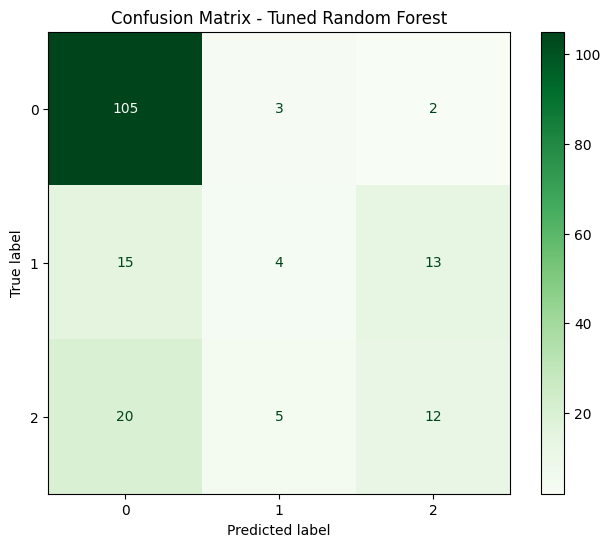

In [13]:
print("\n--- Hyperparameter Tuning for Random Forest using GridSearchCV ---")
param_grid = {
    'n_estimators': [100, 200, 300], # Increased options
    'max_depth': [None, 10, 20, 30], # Increased options
    'min_samples_split': [2, 5, 10], # Increased options
    'min_samples_leaf': [1, 2, 4] # Added min_samples_leaf
}

# 'accuracy' is suitable for balanced multi-class problems. For imbalanced, consider 'f1_weighted'.
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("\nBest Parameters from Grid Search:", gs.best_params_)
print("Best Cross-validation Score from Grid Search:", gs.best_score_)

# Evaluate the best model on the test set
best_rf_model = gs.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test)
print(f"\nClassification Report for Tuned Random Forest Model on Test Set:\n")
print(classification_report(y_test, y_pred_tuned))

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_rf_model, X_test, y_test, cmap=plt.cm.Greens, ax=ax)
ax.set_title("Confusion Matrix - Tuned Random Forest")
plt.show()

### Improvements to GridSearchCV:

* **`param_grid`**: Expanded the range of values for `n_estimators`, `max_depth`, and `min_samples_split`. Also added `min_samples_leaf`, which is another important hyperparameter for Random Forest.
* **`n_jobs=-1`**: Utilizes all available CPU cores, speeding up the search process.
* **`verbose=1`**: Provides output during the search, showing progress.
* **Evaluation on Test Set**: After finding the best parameters, we explicitly evaluate the `gs.best_estimator_` (the model with the best parameters) on the `X_test` and `y_test` to get a final, unbiased performance estimate.

## Step 9: Feature Importance from Best Model

For tree-based models like Random Forest and Decision Tree, we can gain insights into which features were most influential in making predictions. This is known as **feature importance**. Understanding feature importance can help in:

* **Feature Selection**: Identifying and potentially removing less important features to simplify the model and reduce noise.
* **Domain Understanding**: Gaining insights into the underlying relationships in your data.

The `feature_importances_` attribute of a fitted `RandomForestClassifier` (or `DecisionTreeClassifier`) provides a score for each feature, indicating its relative importance. We'll visualize these importances to clearly see which features contributed most to the model's decisions.


--- Feature Importance from Tuned Random Forest Model ---


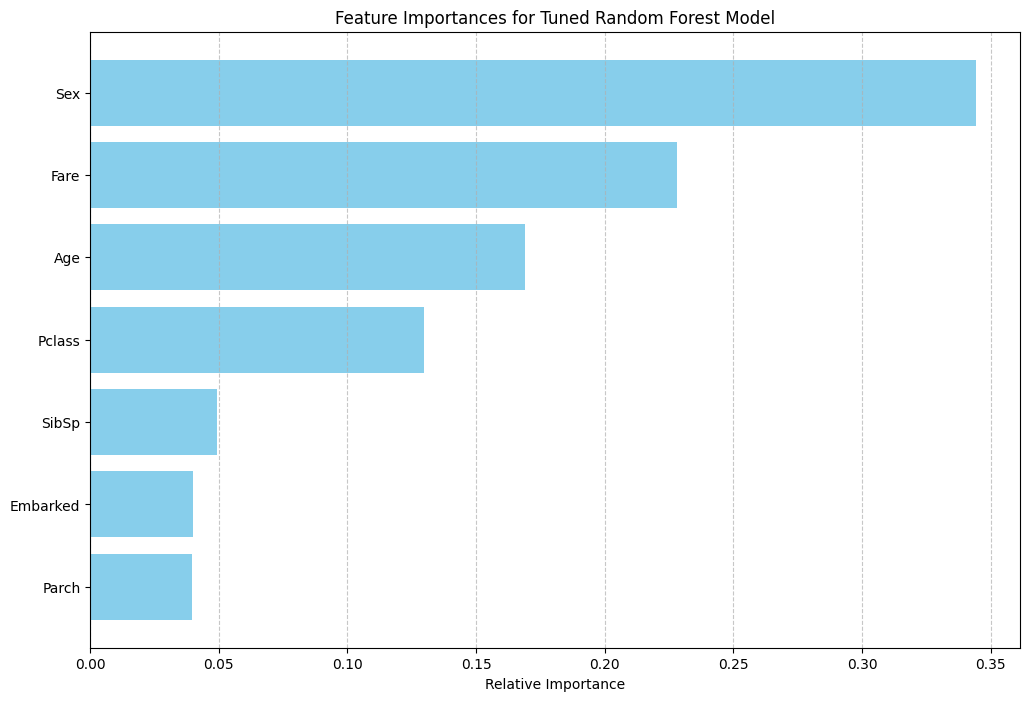


Top 5 Most Important Features:
  Feature  Importance
1     Sex    0.344312
5    Fare    0.227955
2     Age    0.169009
0  Pclass    0.129821
3   SibSp    0.049188


In [14]:
print("\n--- Feature Importance from Tuned Random Forest Model ---")
importances = gs.best_estimator_.feature_importances_
features = X.columns
indices = np.argsort(importances) # Sort features by importance

plt.figure(figsize=(12, 8)) # Increased figure size for better readability
plt.title('Feature Importances for Tuned Random Forest Model')
plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7) # Added grid for readability
plt.show()

# Print feature importances in a more readable format
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nTop 5 Most Important Features:")
print(feature_importance_df.head())

### Explanation:

* **`np.argsort(importances)`**: Returns the indices that would sort the `importances` array, allowing us to plot features from least to most important.
* The bar chart visually represents the relative importance of each feature, making it easy to identify the most impactful ones.

## Conclusion

In this comprehensive tutorial, we successfully walked through a multi-class classification problem using scikit-learn. We covered essential steps in a typical machine learning workflow:

* **Data Loading and Exploration**: Understanding the dataset's structure and contents.
* **Data Preprocessing**: Handling missing values, encoding categorical features, and even simulating a multi-class target variable for demonstration.
* **Feature Selection and Scaling**: Preparing the data for model training.
* **Model Training and Evaluation**: Training several common classification models (Random Forest, SVM, KNN, Decision Tree) and evaluating their performance using classification reports and confusion matrices.
* **Cross-Validation**: Obtaining more robust performance estimates by using cross-validation.
* **Hyperparameter Tuning**: Optimizing the Random Forest model using GridSearchCV to find the best hyperparameters.
* **Feature Importance Analysis**: Gaining insights into which features were most influential for our best model.

This tutorial provides a solid foundation for tackling multi-class classification tasks. To further enhance your skills, you are strongly encouraged to:

* **Explore additional models**: Experiment with advanced models like XGBoost, LightGBM, CatBoost, or Neural Networks.
* **Try different ensemble techniques**: Investigate bagging, boosting, and stacking.
* **Handle imbalanced datasets**: If your multi-class target has very uneven class distributions, explore techniques like SMOTE, ADASYN, or using appropriate evaluation metrics like F1-weighted or ROC AUC for multi-class.
* **Perform more sophisticated feature engineering**: Create new features from existing ones to potentially improve model performance.
* **Experiment with different preprocessing strategies**: For instance, trying one-hot encoding instead of label encoding for nominal categorical features.